In [82]:
%matplotlib inline
from pandas import Series, DataFrame
import pandas as pd
import operator
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import copy
import math
import json
import datetime
from pandas.io.json import json_normalize
matplotlib.rc('font',family='AppleGothic')

In [96]:
def getData(date):
    json_file = open("01_"+str(date)+"_heart.json", 'r')
    json_data = json_file.read()
    json_file.close()
    heart_json = json.loads(json_data)
    json_file = open("01_"+str(date)+"_steps.json", 'r')
    json_data = json_file.read()
    json_file.close()
    step_json = json.loads(json_data)
    json_file = open("01_"+str(date)+"_sleep.json", 'r')
    json_data = json_file.read()
    json_file.close()
    sleep_json = json.loads(json_data)
    heart_json_df = json_normalize(heart_json[ u'activities-heart-intraday'][u'dataset'])
    step_json_df = json_normalize(step_json[u'activities-steps-intraday'][u'dataset'])
    sleep_json_df = json_normalize(sleep_json[u'sleep'][0][u'minuteData'])
    sleep_json_df = sleep_json_df.rename(columns = {u'value':u'status'})

    step_json_df = step_json_df.rename(columns = {u'value':u'steps'})
    heart_json_df = heart_json_df.rename(columns = {u'value': u'heart_beat'})
    sleep_json_df = sleep_json_df.rename(columns = {u'dateTime':u'time'})
    sleep_json_df = sleep_json_df.fillna(4)
    for t in range(len(sleep_json_df[u'time'])):
        sleep_json_df[u'time'][t] = sleep_json_df[u'time'][t].split(':')[0] + ':' + sleep_json_df[u'time'][t].split(':')[1] + u':00'
        
    merge_data = step_json_df.merge(heart_json_df, left_on = u'time', right_on = u'time', how = 'outer')
    multiple_merge_data = merge_data.merge(sleep_json_df, left_on = u'time', right_on = u'time', how = 'outer')
    for t in range(len(multiple_merge_data[u'status'])):
        if pd.isnull(multiple_merge_data[u'status'][t]):
            multiple_merge_data[u'status'][t] = 4
    return multiple_merge_data

In [97]:
data_list = [20160401, 20160402, 20160403, 20160404, 20160405, 20160406, 20160407]
data_frame_list = list()
print "create training data set"
for i in data_list:
    print i
    data_frame_list.append(getData(i)) 

training_data = pd.concat(data_frame_list)
data_list = [20160408, 20160409]
data_frame_list = list()
print "create test data set"
for i in data_list:
    print i
    data_frame_list.append(getData(i)) 

test_data = pd.concat(data_frame_list)

create training data set
20160401
20160402
20160403
20160404
20160405
20160406
20160407
create test data set
20160408
20160409


/Library/Python/2.7/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


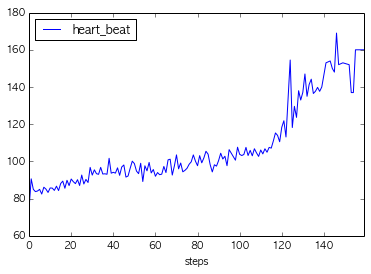

In [98]:
step_per_heat = training_data.groupby([u'steps']).mean()
step_per_heat.to_csv('average_heart_beat_per_steps.csv')
step_per_heat.plot()
test_step_per_heat = test_data.groupby([u'steps']).mean()
test_step_per_heat.to_csv('test_average_heart_beat_per_steps.csv')

In [99]:
dataset = pd.read_csv('average_heart_beat_per_steps.csv')
X = dataset[u'steps'].tolist()
Y = dataset[u'heart_beat'].tolist()

dataset = pd.read_csv('test_average_heart_beat_per_steps.csv')
testX = dataset[u'steps'].tolist()
testY = dataset[u'heart_beat'].tolist()

('Coefficients:', array([ 0.39542979]))
RMSE: 11.22
Variance score: -1.00


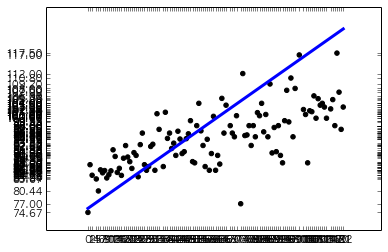

In [101]:
from sklearn import datasets
from sklearn.linear_model import LinearRegression
train_x, test_x = np.array(X), np.array(testX)
train_y, test_y = np.array(Y), np.array(testY)
train_x = train_x.reshape(-1, 1)
test_x =test_x.reshape(-1, 1)
regr = LinearRegression()
regr.fit(train_x, train_y)
print('Coefficients:', regr.coef_)
print("RMSE: %.2f" % np.sqrt(np.mean((regr.predict(test_x) - test_y) ** 2)))
print('Variance score: %.2f' % regr.score(test_x, test_y))
plt.scatter(test_x, test_y,  color='black')
plt.plot(test_x, regr.predict(test_x), color='blue', linewidth=3)
plt.xticks(test_x)
plt.yticks(test_y)
plt.show()

('Coefficients:', array([ -3.71046943e-01,   4.13624844e-02,  -9.11855781e-04,
         7.62848920e-06,  -2.09567280e-08]))
RMSE: 7.35
Variance score: 0.14


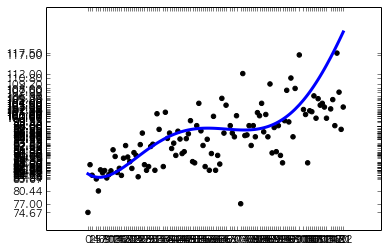

In [120]:
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
train_x, test_x = np.array(X), np.array(testX)
train_y, test_y = np.array(Y), np.array(testY)
train_x = train_x.reshape(-1, 1)
test_x =test_x.reshape(-1, 1)
polynomial_features = PolynomialFeatures(degree=5,include_bias=False)
regr = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", regr)])
pipeline.fit(train_x, train_y)
print('Coefficients:', regr.coef_)
print("RMSE: %.2f" % np.sqrt(np.mean((pipeline.predict(test_x) - test_y) ** 2)))
print('Variance score: %.2f' % pipeline.score(test_x, test_y))
plt.scatter(test_x, test_y,  color='black')
plt.plot(test_x, pipeline.predict(test_x), color='blue', linewidth=3)
plt.xticks(test_x)
plt.yticks(test_y)
plt.show()

In [142]:
average_heat_pet_steps_with_status =  training_data.groupby([u'steps', u'status']).mean()
average_heat_pet_steps_with_status.to_csv('average_heart_beat_per_steps_with_status.csv')
test_average_heat_pet_steps_with_status =  test_data.groupby([u'steps', u'status']).mean()
test_average_heat_pet_steps_with_status.to_csv('test_average_heart_beat_per_steps_with_status.csv')

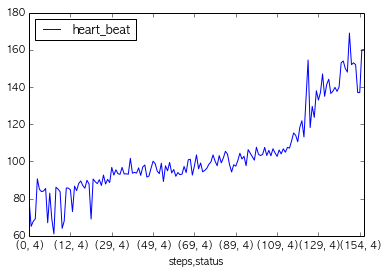

In [143]:
average_heat_pet_steps_with_status.plot()

In [151]:
dataset = pd.read_csv('average_heart_beat_per_steps_with_status.csv')
X1 = dataset[u'steps'].tolist()
X2 = dataset[u'status'].tolist()
Y = dataset[u'heart_beat'].tolist()
X = zip(X1, X2)
dataset = pd.read_csv('test_average_heart_beat_per_steps_with_status.csv')
testX1 = dataset[u'steps'].tolist()
testX2 = dataset[u'status'].tolist()
testX = zip(testX1, testX2)
testY = dataset[u'heart_beat'].tolist()

('Coefficients:', array([  2.45291190e+00,   3.64328773e+01,   3.60541915e-01,
        -3.79421457e+00,  -1.61382850e+01,   4.65477499e-05,
        -9.18348614e-02,   8.23243081e-01,   2.41345426e+00]))
RMSE: 7.49
Variance score: 0.28


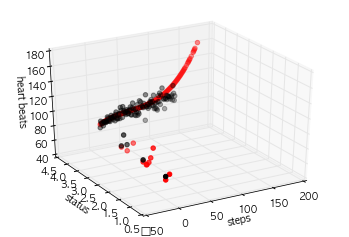

In [179]:
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import interactive
train_x, test_x = np.array(X), np.array(testX)
train_y, test_y = np.array(Y), np.array(testY)

polynomial_features = PolynomialFeatures(degree=3,include_bias=False)
regr = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", regr)])
pipeline.fit(train_x, train_y)
print('Coefficients:', regr.coef_)
print("RMSE: %.2f" % np.sqrt(np.mean((pipeline.predict(test_x) - test_y) ** 2)))
print('Variance score: %.2f' % pipeline.score(test_x, test_y))
threed_graph = plt.figure().gca(projection='3d')
threed_graph.scatter(train_x.T[0].tolist(), train_x.T[1].tolist(),  pipeline.predict(train_x).tolist(),  color='red')
threed_graph.scatter(test_x.T[0].tolist(),  test_x.T[1].tolist(), test_y.tolist(),  color='black')
threed_graph.set_xlabel('steps')
threed_graph.set_ylabel('status')
threed_graph.set_zlabel('heart beats')
threed_graph.view_init(30, 240)
plt.draw()

In [154]:
print train_x.shape
print test_x.shape

(163, 2)
(121, 2)
